ROC (Receiver Operating Characteristic) 曲线是常用的评估binary classifier (二值分类器)预测结果的一个工具。一般来说, 我们会将ROC和AUC (Area Under Curve) 放在一起, ROC作为一条评估曲线, AUC代表的是该ROC曲线下的面积. 在理解ROC的同时, 我们必须引入另一个常用的评估工具: confusion matrix (混淆矩阵), ROC的计算也是基于混淆矩阵的结果来进行的.

在实际应用中, 想要调用ROC曲线是相当简单的, one line of code will do everything for you; 但是, 这个概念是很多同学不理解的。讲再多的理论不如自己实践一下, 今天我们就带大家手把手的使用模拟数据, 手动写出ROC曲线并且和build-in function的结果进行对比。

In [1]:
#首先导入基本数据库
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve,auc,confusion_matrix,plot_confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

## 模拟数据集

模拟500个样本, 为了可以重造这个试验, 我们设置一个seed, 这样随机数就是固定的了.

In [2]:
#使用模拟构造数据集 simulated true labels and probability
np.random.seed(3000) #set seed so the results are reproducible
# 模拟500个样本
#初始化样本标签，假设1为正例，0为负例
train_label = np.random.randint(0,2,size=500)

#产生500个概率值（置信度），即单个样本值为正例的概率, round为小数
train_prob = np.random.rand(500).round(2)

In [3]:
# Combine arrays to be data frame to better visilize it
df = pd.DataFrame(np.c_[train_prob,train_label],columns=['Prob','True_label'])
df.head()

,Prob,True_label
0,0.33,0.0
1,0.87,1.0
2,0.01,0.0
3,0.12,1.0
4,0.23,0.0


可以看到每个case都被赋值了一个概率 (prob) 和一个实际值 (true label)

现在数据已经都模拟好了, 下一步就是来看看ROC曲线要怎么手动实现了.

ROC曲线, 归根到底, 是N组 (FPR, TPR)画出的曲线. 所以在实现之前, 我们要了解什么是FPR, TPR.

## 构造confusion matrix
首先, 我们需要了解Confusion matrix; 在二分类问题中, 我们用confusion matrix来展现分类器的预测结果.

通常会有个**四个**重要数值: 

**True Positive (tp)**: 实际值为1, 预测值也为1

**True Negative (tn):** 实际值为0, 预测值也为0

**False Positive (fp)**: 实际值为0, 而预测值为1

**False Negative (fn)**: 实际值为1, 预测值为0

我们常说的accuracy, recall,  sensitivity等等指标就是由这四个重要的数值衍生而来. 具体每个指标的计算和应用场景我们会在另一篇文章里介绍.

一个general的confusion matrix如图所示:(还没format好)

|             |              |               Predicted Labels ||
|-------------|--------------|:-------------:|-----------------:|
|             |              |  Negative (0) |     Positive (1) |
| True Labels | Negative (0) |    TN   |              FP |
|             | Positive (1) | FN |               TP |

回到绘制ROC曲线所需要的指标:

TPR = $\frac{tp}{tp + fn}$: 在所有实际值为1的case里, 有多少被分类器成功预测为1

FPR = $\frac{fp}{fp+tn}$: 在所有实际值为0的case里,有多少被分类器成功预测为0

### An example using the most common used threshold 

我们现在就来看看在threshold 为0.5的情况下, 我们的FPR, TPR分别是多少

Threshold为0.5, 表示分类器会将所有probability ≥ 0.5的case赋值预测为1

In [4]:
# copy df for this case
df_threshold_half = df.copy()
#assign predicted labels
df_threshold_half['pred_lebel'] = df_threshold_half['Prob'].apply(lambda x: 1 if x>=0.5 else 0)
#查看一下前几行的赋值情况
df_threshold_half.head()

,Prob,True_label,pred_lebel
0,0.33,0.0,0
1,0.87,1.0,1
2,0.01,0.0,0
3,0.12,1.0,0
4,0.23,0.0,0


In [5]:
# get the confusion matrix
cm = confusion_matrix(df_threshold_half.True_label, df_threshold_half.pred_lebel)
cm

array([[142, 113],
       [120, 125]], dtype=int64)

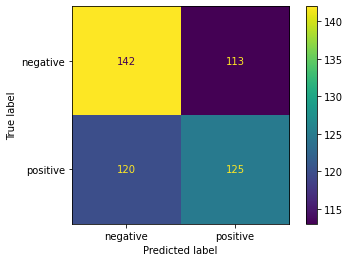

In [6]:
# display confusion matrix
cmd = ConfusionMatrixDisplay(cm, display_labels=['negative','positive'])
cmd.plot()

In [7]:
# get the tn,tp,fn,fp
tn, fp, fn, tp = confusion_matrix(df_threshold_half.True_label, df_threshold_half
                                  .pred_lebel).ravel()
(tn, fp, fn, tp)

(142, 113, 120, 125)

In [8]:
# ROC essentially is a plot of a number of (fpr, tpr) pairs.
# with threshold = 0.5, we have 
# TPR = TP/(TP+FN) = 125/(125+120) = 0.51
# FPR = FP/(TN+FP) = 113/(113+142) = 0.44
# now we have a pair of (0.44,0.51)
TPR = tp/(tp+fn)
FPR = fp/(tn+fp)
print("Under threshold = 0.5: (FPR, TPR) = ({:.2f},{:.2f})".format (FPR,TPR))

Under threshold = 0.5: (FPR, TPR) = (0.44,0.51)


文章开头提过, ROC曲线是通过N组(FPR, TPR)绘制出来的. 那么其他组的(FPR, TPR)要怎么得到呢? 

答案: 我们可以通过不断改变threshold来得到. 当我们有100组threshold时, 比如 threshold = [0.00,0.01,0.02,...,0.098,0.099,1.00]时, 我们就会得到100组 (FPR, TPR), 然后就可以轻松绘制ROC曲线了

我们这里快速的讲threshold设置为0.9给大家展示在阈值为0.9的情况下(既probability ≥ 0.9的case会被赋值预测为1), (FPR, TPR)分别是多少...

### Change of threshold
我们这里快速的讲threshold设置为**0.9**给大家展示在阈值为0.9的情况下(既probability ≥ 0.9的case会被赋值预测为1),（FPR, TPR)的赋值

In [9]:
# when threshold = 0.9, any case with probility greater or equal to 0.9 will be labelled as 1
# since we increase the threhsold dramatically, we expect the predicted number of positive cases is much smaller
df_threshold_nine = df.copy()
df_threshold_nine['pred_lebel'] = df_threshold_half['Prob'].apply(lambda x: 1 if x>=0.9 else 0)

In [10]:
df_threshold_nine.head()

,Prob,True_label,pred_lebel
0,0.33,0.0,0
1,0.87,1.0,0
2,0.01,0.0,0
3,0.12,1.0,0
4,0.23,0.0,0


In [11]:
cm = confusion_matrix(df_threshold_nine.True_label, df_threshold_nine.pred_lebel)
cm

array([[233,  22],
       [218,  27]], dtype=int64)

In [12]:
tn, fp, fn, tp = confusion_matrix(df_threshold_nine.True_label, df_threshold_nine
                                  .pred_lebel).ravel()
(tn, fp, fn, tp)


(233, 22, 218, 27)

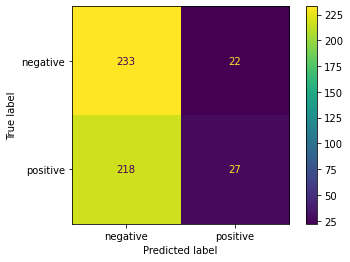

In [13]:
cmd = ConfusionMatrixDisplay(cm, display_labels=['negative','positive'])
cmd.plot()

In [14]:
TPR = tp/(tp+fn)
FPR = fp/(tn+fp)
#TPR.round(2)
#FPR.round(2)
# now we have another pair of (fpr,tpr) = (0.09,0.11)
print("Under threshold = 0.9: (FPR, TPR) = ({:.2f},{:.2f})".format (FPR,TPR))

Under threshold = 0.9: (FPR, TPR) = (0.09,0.11)


可以看到threshold = 0.9的情况下, (FPR, TPR) = (0.09,0.11)

### Performance of the threshold (may delete)
We may evaluate the model using different indicators like accuracy, recall, precision, etc

In [15]:
# function of performance
def compute_performance(tn, fp, fn, tp):
    print(f"tp: {tp} tn: {tn} fp: {fp} fn: {fn}")
    
    # Accuracy
    acc = (tp + tn) / (tp + tn + fp + fn)
    
    # Precision
    # "Of the ones I labeled +, how many are actually +?"
    precision = tp / (tp + fp)
    
    # Recall
    # "Of all the + in the data, how many do I correctly label?"
    recall = tp / (tp + fn)    
    
    # Sensitivity
    # "Of all the + in the data, how many do I correctly label?"
    sensitivity = recall
    
    # Specificity
    # "Of all the - in the data, how many do I correctly label?"
    specificity = tn / (fp + tn)
    
    print("Accuracy:",round(acc,3),"Recall:",round(recall,3),"Precision:",round(precision,3),
          "Sensitivity:",round(sensitivity,3),"Specificity:",round(specificity,3))

In [16]:
# An example usingwhile threshold = 0.9
compute_performance(tn, fp, fn, tp)

tp: 27 tn: 233 fp: 22 fn: 218
Accuracy: 0.52 Recall: 0.11 Precision: 0.551 Sensitivity: 0.11 Specificity: 0.914


## 使用循环构造TPR, FPR组
现在大家已经知道了 FPR, TPR的计算方法. 我们可以通过设置不同threshold, 来得到100组 （FPR, TPR). Python中我们可以用循坏来实现

In [17]:
#let's define a function to compute all pairs
def ROC_pair(threshold):
    df_copy = df.copy()
    df_copy['pred_lebel'] = df_copy['Prob'].apply(lambda x: 1 if x>=threshold else 0)
    tn, fp, fn, tp = confusion_matrix(df_copy.True_label, df_copy.pred_lebel).ravel()
    TPR = tp/(tp+fn)
    FPR = fp/(tn+fp)
    return (TPR.round(2),FPR.round(2))

In [18]:
range = np.linspace(0,1,100)
data = []
for i in range:
    TPR,FPR = ROC_pair(i)
    data.append([i, FPR, TPR])
    
ROC_df = pd.DataFrame(data, columns=['threshold', 'FPR', 'TPR'])

In [19]:
ROC_df

,threshold,FPR,TPR
0,0.000000,1.00,1.00
1,0.010101,0.99,0.99
2,0.020202,0.98,0.97
3,0.030303,0.97,0.96
4,0.040404,0.96,0.95
...,...,...,...
95,0.959596,0.04,0.06
96,0.969697,0.02,0.05
97,0.979798,0.02,0.04
98,0.989899,0.01,0.03


## 使用build-in function进行对比

In [20]:
# 使用build-in function得到TPR,FPR
fpr, tpr, thresholds = roc_curve(df.True_label, df.Prob)

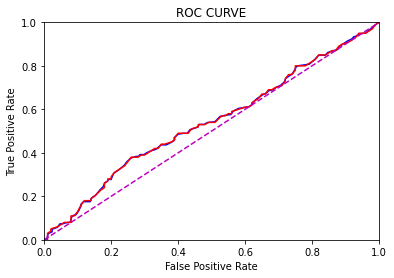

In [21]:
plt.figure()
plt.title('ROC CURVE')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
# 为了展示两条线是几乎重叠的就没有round, 不然两条线就是一条线
# plt.plot(np.round(fpr,2),np.round(tpr,2),color='g')
plt.plot(fpr,tpr,color='b') #build-in function下的ROC曲线为蓝色
plt.plot(ROC_df.FPR.values,ROC_df.TPR.values, color = 'r') #手动实现的ROC曲线为红色
plt.plot([0, 1], [0, 1], color='m', linestyle='--')
plt.show()

可以看到手动实现下的ROC曲线和使用build-in function下绘制出的曲线是完全重合的.

由于是simulation数据(基于正态分布且没有skew), ROC曲线看起来没有那么好看 (几乎就是0.5), 实际比较准确的模型比这个曲线好看多了 :)

## 优缺点

通过ROC空间，我们明白了一条ROC曲线其实代表了无数个分类器。那么我们为什么常常用一条ROC曲线来描述一个分类器呢？仔细观察ROC曲线，发现其都是上升的曲线（斜率大于0），且都通过点（0,0）和点（1,1）。其实，这些点代表着一个分类器在不同阈值下的分类效果，具体的，曲线从左往右可以认为是阈值从0到1的变化过程。当分类器阈值为1，代表不加以识别全部判断为0，此时TP=FP=0，TPR=TP/P=0，FPR=FR/N=0；当分类器阈值为0，代表不加以识别全部判断为1，此时FN=TN=0，P=TP+FN=TP, TPR=TP/P=1，N=FP+TN=FP, FPR=FR/N=1。

ROC curve 可以很好的回答什么问题呢——“不论class的基本概率怎么样，我的模型in general能表现得多好？”

所以，ROC曲线描述的其实是分类器性能随着分类器阈值的变化而变化的过程。对于ROC曲线，一个重要的特征是它的面积，面积为0.5为随机分类，识别能力为0，面积越接近于1识别能力越强，面积等于1为完全识别。具体的，可以参考了解ROC曲线下面积，我们会在下篇文章里介绍